# Alarm Title Encoding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore,Back,Style
import glob
from ast import literal_eval
import re
import os
#import tensorflow as tf
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer, models, InputExample, losses, util
from torch.utils.data import DataLoader
import torch.utils
from transformers import AutoTokenizer, DataCollatorWithPadding
#from transformers.keras_callbacks import KerasMetricCallback
from  sklearn.model_selection import train_test_split
from  sklearn.preprocessing import LabelEncoder
import evaluate

### Preprocess the Alarm Titles (Tokenize)

In [2]:
titles_df = pd.read_csv('./Data/alarm_titles_labeled.csv')
# titles_df = pd.read_csv('./Data/nce_all_names.csv')
#titles_df['System']='NCE'
titles_df=titles_df[~titles_df['Title'].isnull()]
print(f'Number of Titles= {len(titles_df)}')


Number of Titles= 1045


In [3]:
tokenizer = AutoTokenizer.from_pretrained('./distilbert-base-uncased')
# tokenizer.get_vocab()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
def preprocess_titles(title):
    return tokenizer(title, truncation=True)
tokenized_titles = titles_df['Title'].apply(preprocess_titles)

### Encode Class label (Label Encoder)

In [ ]:
def concate_classes(row):
    return ' '.join(str(row[col]) for col in ['Class0', 'Class2','Class1'])
titles_df['class']=titles_df.apply(concate_classes,axis=1)
label_encoder=LabelEncoder()
titles_df['label'] = label_encoder.fit_transform(titles_df['class'])
# titles_df['label'] = titles_df['class'].apply(classEncoder.transform)
classes = titles_df['class'].drop_duplicates()
print(f'Number of unique titles: {len(classes)}')
labels = LabelEncoder().fit_transform(classes)
# id2label = {int(i): str(label) for i, label in zip(labels, classes)}
# label2id = {str(label): int(i) for i, label in zip(labels, classes)}

id2label={}
for i , ii in zip(labels, classes):
    id2label[int(i)]=ii
id2label  

label2id={}
for i , ii in zip(classes,labels):
    label2id[i]=int(ii)


## Approach1: Title Classification using Tensorflow TFAutoModel

In [ ]:
from transformers import create_optimizer
batch_size = 8
num_epochs = 10
batches_per_epoch = len(tokenized_titles) // batch_size
total_train_steps = int(batches_per_epoch*num_epochs)
optimizer, schedule = create_optimizer(init_lr=1e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

In [ ]:
from transformers import TFAutoModelForSequenceClassification,AutoConfig,TrainingArguments,Trainer
title_label_num = titles_df['label'].nunique()

TFmodel = TFAutoModelForSequenceClassification.from_pretrained('./distilbert-base-uncased', num_labels=title_label_num,
                                                            id2label=id2label, label2id=label2id)

train_titles, test_titels = train_test_split(tokenized_titles, test_size=.2, shuffle=True)

train_set = TFmodel.prepare_tf_dataset(train_titles, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
test_set = TFmodel.prepare_tf_dataset(test_titles, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

# a task-relevant Loss is already defined
TFmodel.compile(optimizer=optimizer)

# set the accuracy metric
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=test_set)

# train the model
TFmodel.fit(x=train_set, validation_data=test_set, epochs=10, callbacks=metric_callback)
TFmodel.save('TFSequenceClassificationModel.h5')

### Fine tune a model with the Trainer

## Approach2: Trainig a Sentence Transformer with Pre-trained BERT base

### Testing the out-of-box Best Sentence Transformer

In [ ]:
example_title = 'a network element was not logged in'
related_title = 'link error occurred'
test_model = SentenceTransformer('./all-MiniLM-L6-v2')
# embeddings with 384-dim
print(test_model.encode([example_title, related_title]))

## Training an SBERT from scratch using HuggingFace SentenceTransformer model

In [4]:
from transformers import DistilBertModel, DistilBertTokenizer
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.datasets import SentencesDataset
# download a pre-trained BERT model
WE_model = models.Transformer('distilbert-base-uncased')

# Apply pooling to token embeddings
pooling_model = models.Pooling(WE_model.get_word_embedding_dimension(), pooling_mode_weightedmean_tokens=True)
#pooling_model = models.Dense(in_features=WE_model.get_word_embedding_dimension(), out_features=1)

# using the pytorch-based sentence transformer module
PTmodel = SentenceTransformer(modules=[WE_model, pooling_model])

### Getting Our Triplet Dataset (titles with category labels)

In [5]:
def extract_nonsimilars(raw):
    return [raw['Neighbors'][i] for i in raw['Unrelevants']]

val_df = pd.read_csv(r'./Data/Alarm_Titles_Neighbors_Tarek_validation.csv', converters={"Neighbors": literal_eval, "Unrelevants": literal_eval})
non_similars = val_df.apply(extract_nonsimilars, axis=1)


In [6]:
n_titles = len(titles_df)
train_titles = []
view_list = []
labels=[]
for i in range(n_titles):
    label = ['Category', 'Level']
    query = titles_df.iloc[i]['Title']
    query_label = titles_df[label].iloc[i]
    cond = titles_df[label] == query_label
    rel_cond = np.logical_and.reduce(cond, axis=1)
    unrel_cond = ~np.logical_or.reduce(cond, axis=1)
    related = titles_df[rel_cond].sample()['Title'].iloc[0]
    if not non_similars[i]:
        unrelated = titles_df[unrel_cond].sample()['Title'].iloc[0]
    else:
        unrelated = non_similars[i][0]
    view_list.append([query, related, unrelated])
    train_titles.append(InputExample(texts=[query, related, unrelated]))
    labels.append(' '.join(str(col) for col in query_label))


## Training the model

In [13]:

train_dataset=SentencesDataset(train_titles,PTmodel)
train_dataLoader = DataLoader(train_dataset, shuffle=True, batch_size=8)

# Losses: batchHardTripletLoss, BatchAllTripletLoss, BatchHardSofMarginTripletLoss, BatchSemiHardTripletLoss
train_loss = losses.TripletLoss(model=PTmodel)#,distance_metric=losses.TripletDistanceMetric.COSINE)

PTmodel.fit(train_objectives=[(train_dataLoader, train_loss)], epochs=3)

save_dir = 'trained_models'
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_path = os.path.join(save_dir, f'model_tripletloss_with_nonsimilars.sav')
PTmodel.save(model_path)
print(f'Model trained  saved to {model_path}')

# example_title = ''
# related_title = ''
# print(PTmodel.encode([example_title, related_title]))

c:\Users\User\anaconda3\envs\fms_dl\Lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\User\anaconda3\envs\fms_dl\Lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


  0%|          | 0/393 [00:00<?, ?it/s]

{'train_runtime': 843.3578, 'train_samples_per_second': 3.717, 'train_steps_per_second': 0.466, 'train_loss': 5.057849835500159, 'epoch': 3.0}
Model trained  saved to trained_models\model_tripletloss_with_nonsimilars.sav


In [ ]:
PTmodel.fit(train_objectives=[(train_dataLoader, train_loss)], epochs=5)

In [ ]:
PTmodel = SentenceTransformer('trained_models/model_tripletloss.sav')

### TSNE Visualization

C:\Users\User\AppData\Local\Temp\ipykernel_10728\2676582070.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels))


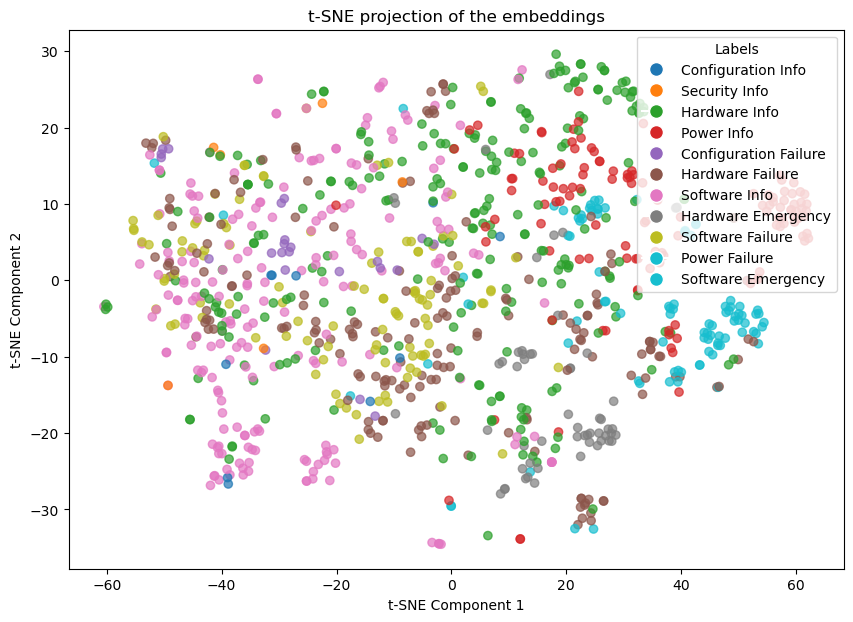

In [14]:
# Get the embeddings
sentences=titles_df['Title'].to_list()
embeddings = PTmodel.encode(sentences)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Map labels to integers
unique_labels = list(set(labels))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_labels = [label_to_int[label] for label in labels]

# Create a colormap
cmap = plt.cm.get_cmap('tab10', len(unique_labels))

# Plot t-SNE results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=int_labels, cmap=cmap, alpha=0.7)
# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(unique_labels))]
plt.legend(handles, unique_labels, title="Labels")
plt.title("t-SNE projection of the embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

### Semantic Search

In [ ]:
#queries = [
#   'a link was disconnected',
#    'the device was offline'
#]
queries= [
'the First Fan Stopped working',
'the Clock Link Failed in the Internet Protocol',
'the Alternating Current source Charge Failed',
'the configuration was Not Supported' # Config Failure Functional
]
top_k = 3
for query in queries:
    query_embedding = PTmodel.encode(query, convert_to_tensor=True)
    similar_results = util.semantic_search(query_embeddings = query_embedding, corpus_embeddings=embeddings,top_k=top_k)
    print(f"\nTop 3 most similar sentences for {query}:")
    val_labels = []
    for result in similar_results[0]:
        val_labels.append(labels[result['corpus_id']])
        print(Fore.BLUE,f"Alarm Title:",Style.RESET_ALL,f"{sentences[result['corpus_id']]}.",Fore.BLUE,"Label:",Style.RESET_ALL,f"{labels[result['corpus_id']]}.(",Fore.BLUE,"score:",Style.RESET_ALL,f"{result['score']})")
        print("===============\n")
    #plt.figure()
    #plt.hist(val_labels)
    #plt.xticks(rotation=90)

In [28]:
top_k = 8
result_df = pd.DataFrame()
result_df['Title'] = titles_df['Title'].copy()
result_df['Neighbors'] = titles_df['Title'].copy()
result_df['Technical Feedback'] = titles_df['Title'].copy()
def func(query):
    query_embedding = PTmodel.encode(query, convert_to_tensor=True)
    similar_results = util.semantic_search(query_embeddings = query_embedding, corpus_embeddings=embeddings,top_k=top_k)
    val_labels, val_neighbors = [], []
    for result in similar_results[0][1:]:
        val_labels.append(labels[result['corpus_id']])
        val_neighbors.append(sentences[result['corpus_id']])
        #print(Fore.BLUE,f"Alarm Title:",Style.RESET_ALL,f"{sentences[result['corpus_id']]}.",Fore.BLUE,"Label:",Style.RESET_ALL,f"{labels[result['corpus_id']]}.(",Fore.BLUE,"score:",Style.RESET_ALL,f"{result['score']})")
        #print("===============\n")
    return val_neighbors
    
result_df['Neighbors'] = result_df['Title'].apply(func)
result_df['Technical Feedback'] = result_df['Technical Feedback'].apply(lambda x: '')

In [16]:
result_df.to_csv('./Data/Alarm_Titles_Neighbors.csv')

### Alarm similarity check with continuous checking test 

In [35]:
seed = np.random.randint(0, len(titles_df))
alarm = titles_df['Title'].iloc[seed]
alarm_list = [alarm]
stop = False
while True:
    similars = result_df[result_df['Title'] == alarm]['Neighbors'].iloc[0]
    for i, sample in enumerate(similars):
        if sample not in alarm_list:
            alarm_list.append(sample)
            alarm = sample
            break
        if i == len(similars)-1:
            stop = True
    if stop:
        break
alarm_list

['a Defect was Indicated in the Microwave Remote system',
 'a Remote Defect was Indicated at the Ethernet Connectivity Fault Management',
 'a core network Node Flow Control issue was recorded',
 'an Interface congestion was recorded',
 'system configuration error was registered',
 'bad performance was detected',
 'an Excessive License Usage was detected',
 'an Internet Protocol Attack was detected',
 'Physical Link Aggregation packet triggered an error',
 'a link failed in the Message Transfer User Adaptation Layer',
 'the Message Transfer User Adaptation Layer link failed',
 'Message Transfer User Adaptation Layer Link Failed',
 'Message Transfer User Adaptation Layer link set failed',
 'Message Transfer User Adaptation Layer Signaling Link Failed',
 'Message Transfer User Adaptation Layer Signaling Link was Congested',
 'the Message Transfer User Adaptation Layer link was congested',
 'A Message Transfer User Adaptation Layer association was congested',
 'the Message Transfer User Ad

## Training an SBERT from scratch using TensorFlow TFAutoModel

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer, models, losses, InputExample
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import os

# Define the pooling modes and loss functions to experiment with
# pooling_modes = ['mean', 'max', 'cls', 'lasttoken','mean_sqrt_len_tokens', 'weightedmean']
pooling_modes = [ 'cls', 'lasttoken','mean_sqrt_len_tokens', 'weightedmean']
loss_functions = [losses.TripletLoss, losses.BatchHardTripletLoss, losses.BatchAllTripletLoss, losses.BatchHardSoftMarginTripletLoss, losses.BatchSemiHardTripletLoss]

# Define the directory to save the models
output_dir = "models"
# os.makedirs(output_dir, exist_ok=True)

n_titles = len(titles_df)
train_titles = []
labels=[]
for i in range(n_titles):
    if titles_df.iloc[0]['System'] == 'NCE':
        label = ['Class0', 'Class1', 'Class2']
    query = titles_df.iloc[i]['Title']
    query_label = titles_df[label].iloc[i]
    cond = titles_df[label] == query_label
    rel_cond = np.logical_and.reduce(cond, axis=1)
    unrel_cond = ~np.logical_or.reduce(cond, axis=1)
    related = titles_df[rel_cond].sample()['Title'].iloc[0]
    unrelated = titles_df[unrel_cond].sample()['Title'].iloc[0]
    train_titles.append(InputExample(texts=[query, related, unrelated]))
    labels.append(' '.join(str(col) for col in query_label))
  

train_dataLoader = DataLoader(train_titles, shuffle=True, batch_size=8)

# Function to train and save the model
def train_and_save_model(pooling_mode, loss_function):
    WE_model = models.Transformer('distilbert-base-uncased')
    pooling_model = models.Pooling(WE_model.get_word_embedding_dimension(), pooling_mode=pooling_mode)
    PTmodel = SentenceTransformer(modules=[WE_model, pooling_model])

    train_loss = loss_function(model=PTmodel)

    PTmodel.fit(train_objectives=[(train_dataLoader, train_loss)], epochs=10)

    # Save the model
    model_save_path = os.path.join(output_dir, f"model_pooling_{pooling_mode}_loss_{loss_function.__name__}")
    PTmodel.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    return PTmodel

# Experiment with different configurations
for pooling_mode in pooling_modes:
    for loss_function in loss_functions:
        print(f"Training with pooling mode: {pooling_mode} and loss function: {loss_function.__name__}")
        model = train_and_save_model(pooling_mode, loss_function)

In [ ]:
pooling_modes = [ 'mean', 'max','cls', 'lasttoken','mean_sqrt_len_tokens', 'weightedmean']
loss_functions = [losses.TripletLoss, losses.BatchHardTripletLoss, losses.BatchAllTripletLoss, losses.BatchHardSoftMarginTripletLoss]

# Function to plot t-SNE embeddings
def plot_tsne_embeddings(model, titles_df, labels,plot_title):
    embeddings = model.encode(titles_df['Title'].tolist())
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    unique_labels = list(set(labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_labels = [label_to_int[label] for label in labels]

    cmap = plt.cm.get_cmap('tab10', len(unique_labels))

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=int_labels, cmap=cmap, alpha=0.7)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(unique_labels))]
    plt.legend(handles, unique_labels, title="Labels")
    plt.title(plot_title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

for pooling_mode in pooling_modes:
    for loss_function in loss_functions:
        model_path = os.path.join(output_dir, f"model_pooling_{pooling_mode}_loss_{loss_function.__name__}")
        loaded_model = SentenceTransformer(model_path)
        plot_title = f"t-SNE projection for pooling: {pooling_mode}, loss: {loss_function.__name__}"
        print(plot_title)
        plot_tsne_embeddings(loaded_model, titles_df, labels, plot_title)
